In [ ]:
machine = 'local'
#macine = 'colab'

if machine == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
import zipfile
zip_ref = zipfile.ZipFile("archive.zip", 'r')
zip_ref.extractall("./content/dataset")
zip_ref.close()

In [4]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

2024-11-05 11:20:49.988891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730802050.000862    6495 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730802050.004498    6495 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 11:20:50.016703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
train_path = './content/dataset/Training'

filepaths = []
labels = []

directories = os.listdir(train_path)
for directory in directories:
    f_path = os.path.join(train_path, directory)
    filelists = os.listdir(f_path)
    filepaths.extend([os.path.join(f_path, file) for file in filelists])
    labels.extend([directory] * len(filelists))

train_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

print(train_frame.shape)

(5712, 2)


In [6]:
test_path = './content/dataset/Testing'

filepaths = []
labels = []

directories = os.listdir(test_path)
for directory in directories:
    f_path = os.path.join(test_path, directory)
    filelists = os.listdir(f_path)
    filepaths.extend([os.path.join(f_path, file) for file in filelists])
    labels.extend([directory] * len(filelists))

test_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

print(test_frame.shape)

(1311, 2)


In [7]:
train, valid = train_test_split(train_frame, train_size=0.9, shuffle=True, random_state=42)

print(train.shape)
print(valid.shape)

(5140, 2)
(572, 2)


In [8]:
img_size = (224, 224)
batch_size = 16
tr_gen = ImageDataGenerator(rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.02,
                            height_shift_range=0.02,
                            horizontal_flip=True)

ts_gen= ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train, x_col = 'filepaths', y_col = 'label', target_size = img_size,
                                      class_mode = 'categorical', color_mode = 'rgb', shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid, x_col = 'filepaths', y_col = 'label', target_size = img_size,
                                       class_mode = 'categorical', color_mode = 'rgb', shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_frame, x_col= 'filepaths', y_col = 'label', target_size = img_size,
                                      class_mode = 'categorical', color_mode= 'rgb', shuffle = False, batch_size = batch_size)



Found 5140 validated image filenames belonging to 4 classes.
Found 572 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [9]:
print(train_gen)

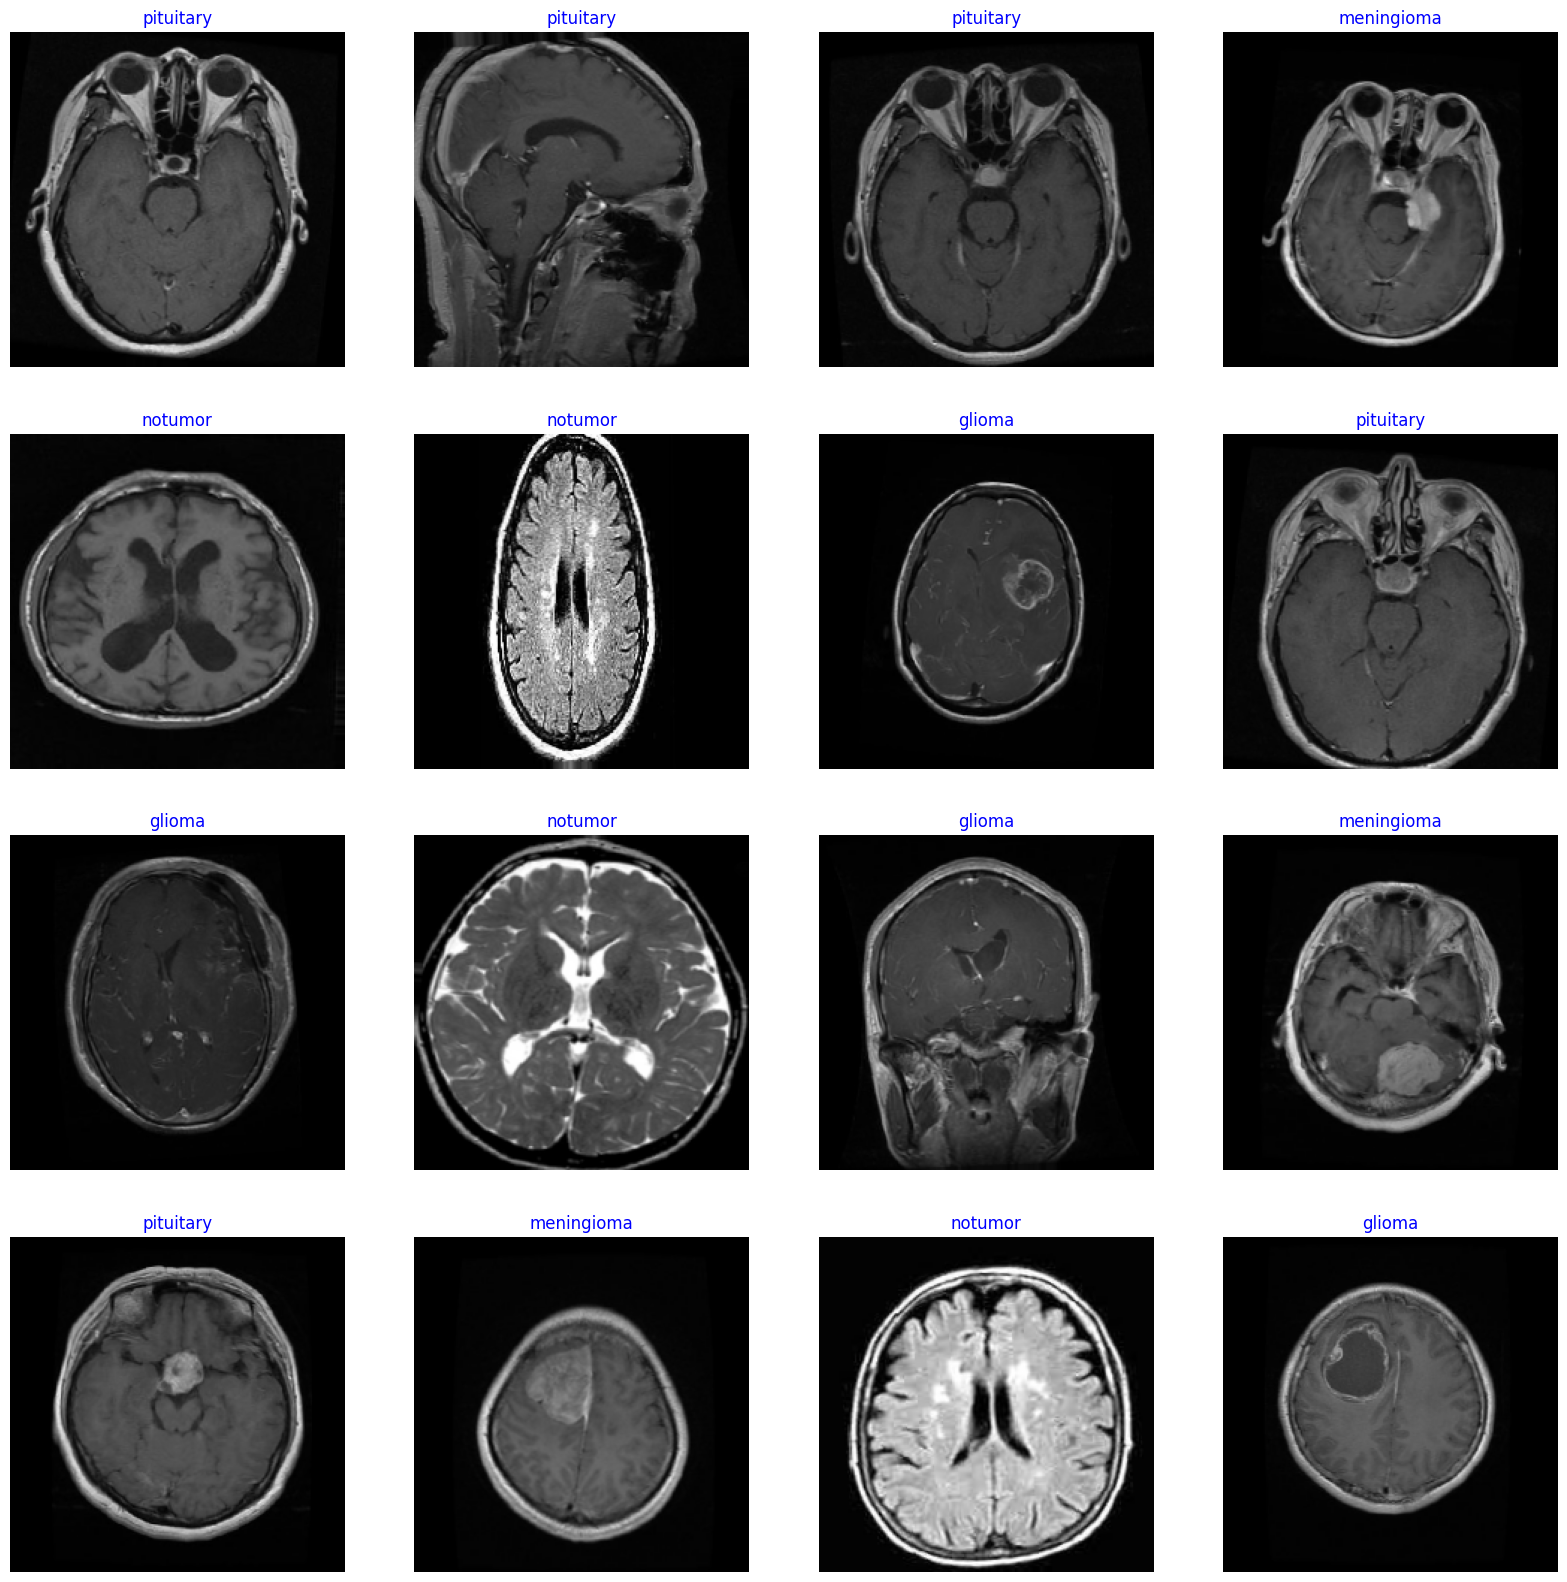

In [10]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < len(images):
        image = images[i]
        ax.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        ax.set_title(class_name, color='blue', fontsize=12)
        ax.axis('off')
    else:
        break

plt.show()

In [11]:
img_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=img_shape,
    pooling='max',
    classes=1000,
)
    
model = Sequential(
    [base_model,
    Flatten(),
    Dense(4, activation='softmax')]
)

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.build(input_shape=(None, 224, 224, 3))
model.summary()

I0000 00:00:1730802053.123362    6495 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
Epochs = 12

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 265s 823ms/step - accuracy: 0.9923 - loss: 0.0296 - val_accuracy: 0.9825 - val_loss: 0.1414
Epoch 2/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 275s 853ms/step - accuracy: 0.9939 - loss: 0.0274 - val_accuracy: 0.9808 - val_loss: 0.1564
Epoch 3/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 272s 844ms/step - accuracy: 0.9947 - loss: 0.0152 - val_accuracy: 0.9790 - val_loss: 0.1669
Epoch 4/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 278s 863ms/step - accuracy: 0.9937 - loss: 0.0232 - val_accuracy: 0.9808 - val_loss: 0.2208
Epoch 5/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 276s 858ms/step - accuracy: 0.9991 - loss: 0.0051 - val_accuracy: 0.9720 - val_loss: 0.2060
Epoch 6/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 275s 852ms/step - accuracy: 0.9933 - loss: 0.0271 - val_accuracy: 0.9755 - val_loss: 0.1766
Epoch 7/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 276s 857ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 0.9773 - val_loss: 0.1523
Epoch 8/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 278s 864ms/step - accuracy: 0.9922 -

Data saved to densenet_training_history.csv


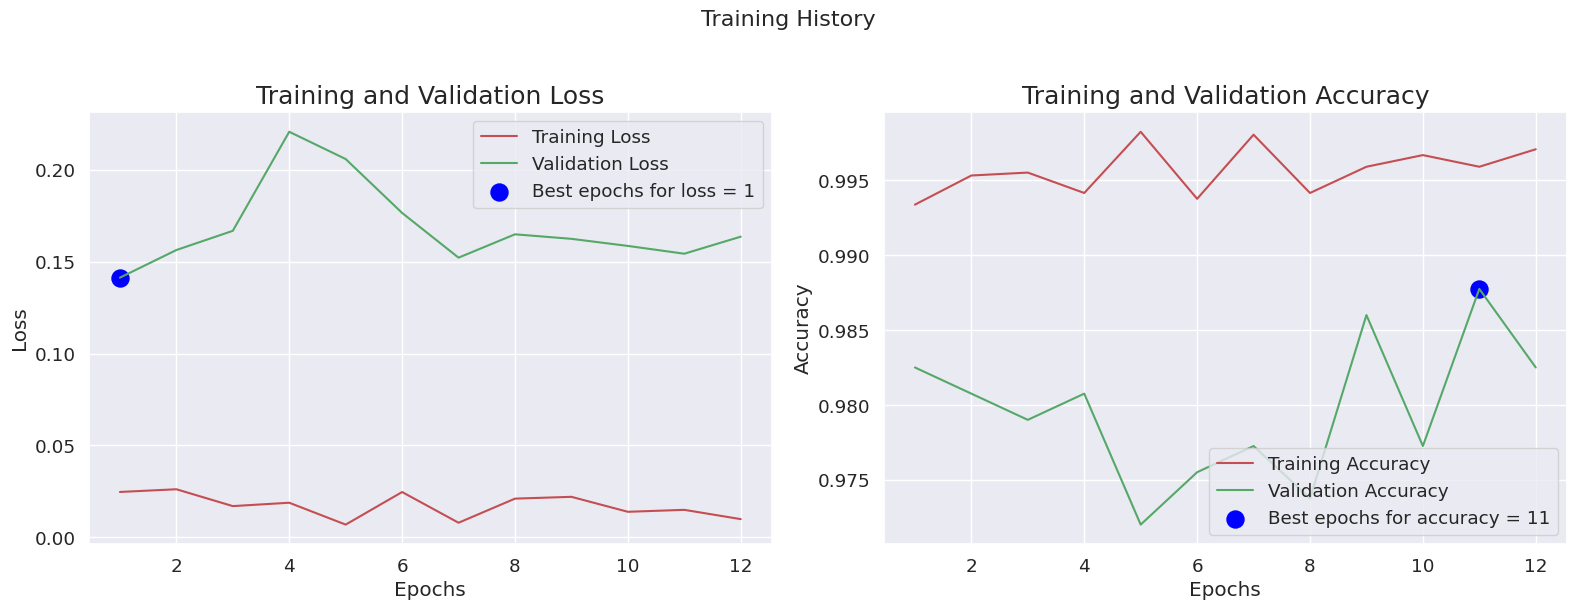

In [19]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f'Best epochs for loss = {str(index_loss + 1)}'
acc_label = f'Best epochs for accuracy = {str(index_acc + 1)}'

data = {
    'Epoch': Epochs,
    'Training Loss': train_loss,
    'Validation Loss': val_loss,
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc
}

df = pd.DataFrame(data)

csv_filename = 'densenet_training_history.csv'
df.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Training History', fontsize=16, y=1.02)

axes[0].plot(Epochs, train_loss, 'r', label='Training Loss')
axes[0].plot(Epochs, val_loss, 'g', label='Validation Loss')
axes[0].scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
axes[0].set_title('Training and Validation Loss', fontsize=18)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(Epochs, train_acc, 'r', label='Training Accuracy')
axes[1].plot(Epochs, val_acc, 'g', label='Validation Accuracy')
axes[1].scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
axes[1].set_title('Training and Validation Accuracy', fontsize=18)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [20]:
sets_to_evaluate = [train_gen, valid_gen, test_gen]
set_names = ["Training", "Validation", "Test"]

steps = len(test_gen)

for set_name, data_gen in zip(set_names, sets_to_evaluate):
    score = model.evaluate(data_gen,
                         steps=len(data_gen),
                         verbose=1)
    loss, accuracy = score
    print(f"{set_name} Loss: {loss}")
    print(f"{set_name} Accuracy: {accuracy}")
    print('-' * 30)

322/322 ━━━━━━━━━━━━━━━━━━━━ 65s 199ms/step - accuracy: 0.9997 - loss: 0.0030
Training Loss: 0.008018789812922478
Training Accuracy: 0.9990272521972656
------------------------------
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9888 - loss: 0.0943
Validation Loss: 0.16371582448482513
Validation Accuracy: 0.9825174808502197
------------------------------
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9938 - loss: 0.0866
Test Loss: 0.08924739807844162
Test Accuracy: 0.9900839328765869
------------------------------


In [21]:
preds = model.predict(test_gen, steps=len(test_gen))
y_pred = np.argmax(preds, axis=1)
print("Number of predictions:", len(y_pred))
print("Number of test samples:", len(test_gen.classes))

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step
Number of predictions: 1311
Number of test samples: 1311


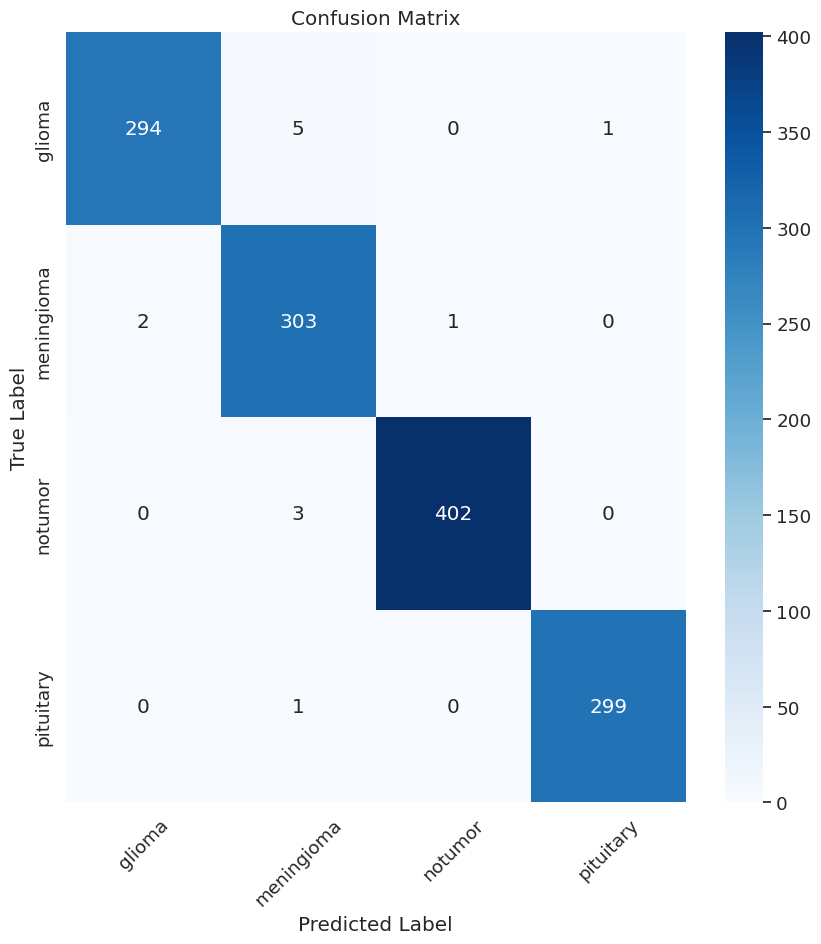

In [22]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.show()

In [23]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       300
  meningioma       0.97      0.99      0.98       306
     notumor       1.00      0.99      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

